In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special
import math

In [3]:
def prepare_data(data):
    X, y = [], []
    for row in data:
        row = row.split(',')
        y.append(int(row[0]))
        inputs = row[1:]
        inputs = [int(i) for i in inputs]
        inputs = [(value / 255 * 1) + 0.00 for value in inputs]
        X.append(inputs)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
path_train = '/content/sample_data/mnist_train_small.csv'
training_data_file = open(path_train, 'r')
training_data_list = training_data_file.readlines()
training_data_list = training_data_list[:1_000]
training_data_file.close()
X, y = prepare_data(training_data_list)
path_test = "/content/sample_data/mnist_test.csv"
test_data_file = open(path_test, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
X_test, y_test = prepare_data(test_data_list)

In [5]:
class Activation_Function:

    def __init__(self, func, deriv, _min, _max):
        self.function = func
        self.derivative = deriv
        self.min = _min
        self.max = _max


class Layer:
    def __init__(self, nodes, act_func):
        self.nodes = nodes
        self.act_func = act_func
        self.error = None
        self.weight = None
        self.output = None
        self.bias = None


class NN_batch:
    def __init__(self, input_nodes, l_r_start=0.1, l_r_end=0.01):
        self.input_nodes = input_nodes
        self.layers = []
        self.learning_rate = None
        self.l_r_start = l_r_start
        self.l_r_end = l_r_end


    def add_layer(self, layer):
        row, column = layer.nodes, self.input_nodes
        self.input_nodes = layer.nodes
        weight = np.random.normal(0.0,
                                  pow(column, -0.5),
                                  (row, column))
        bias = np.random.rand(row).reshape(row, 1)
        layer.bias = bias
        layer.weight = weight
        self.layers.append(layer)
        return self

    def forward_propagation(self, features):
        self.input = features
        for l in self.layers:
            l.output = l.act_func.function(np.dot(l.weight, features) + l.bias)
            features = l.output
        return features


    def backward_propagation(self, error):
        for layer in reversed(self.layers):
            layer.error = error
            error = np.dot(layer.weight.T, error)
        w_remarks = []
        b_remarks = []

        for i in range(len(self.layers) - 1, 0, -1):
            current_layer = self.layers[i]
            previous_layer = self.layers[i - 1]
            weights_correction = self.learning_rate * np.dot(
                np.array((current_layer.error * current_layer.act_func.derivative(current_layer.output)), ndmin=2),
                np.array(previous_layer.output, ndmin=2).T
            )
            current_layer.weight += weights_correction
            bias_correction = self.learning_rate * current_layer.error * current_layer.act_func.derivative(current_layer.output)
            summed_b_c =  np.array(bias_correction.sum(axis=1), ndmin=2).T
            current_layer.bias += summed_b_c

        current_layer = self.layers[0]
        weights_correction = self.learning_rate * np.dot(
            np.array((current_layer.error * current_layer.act_func.derivative(current_layer.output)), ndmin=2),
            np.array(self.input, ndmin=2).T
        )
        current_layer.weight += weights_correction
        bias_correction = self.learning_rate * current_layer.error * current_layer.act_func.derivative(current_layer.output)
        bias_correction = np.array(bias_correction)
        summed_b_c =  np.array(bias_correction.sum(axis=1), ndmin=2).T
        current_layer.bias += summed_b_c

    def fit_batch(self, Xs, ys, batch_size):
        last_layer = self.layers[-1]
        output_nodes = last_layer.nodes
        batch_count = int(math.ceil(len(ys) / batch_size))
        for i in range(batch_count):
            X_batch = Xs[i * batch_size: (i + 1) * batch_size]
            targets = ys[i * batch_size: (i + 1) * batch_size]
            vectored_targets = [np.zeros(output_nodes) - last_layer.act_func.min for i in targets]
            for target_value, zero_vector in zip(targets, vectored_targets):
                zero_vector[target_value] = last_layer.act_func.max

            output = self.forward_propagation(X_batch.T)
            vectored_targets_array = np.array(vectored_targets).T
            errors = vectored_targets_array - output
            self.backward_propagation(errors)


    def fit_epochs_batch(self, Xs, ys, X_test, y_test, epoch_count=15, batch_size=10):
        self.epochs = []
        self.efficiency = []
        self.efficiency_on_train = []
        lrs = np.linspace(self.l_r_start, self.l_r_end, epoch_count)
        for e in range(epoch_count):
            self.learning_rate = lrs[e]
            self.fit_batch(Xs, ys, batch_size)
            self.efficiency.append(self.calc_efficiency(X_test, y_test))
            self.epochs.append(e)


    def predict(self, x_):
        x_ = np.array(x_, ndmin=2).T
        return self.forward_propagation(x_)


    def calc_efficiency(self, test_X, test_y):
        scorecard = []
        for (inputs, outputs) in zip(test_X, test_y):
            correct_label = outputs
            result = self.predict(inputs)
            self_label = np.argmax(result)
            if correct_label == self_label:
                scorecard.append(1)
            else:
                scorecard.append(0)
        scorecard_array = np.array(scorecard)
        return scorecard_array.sum() / scorecard_array.size


In [6]:
k = 1

sigmoid = Activation_Function(lambda x:scipy.special.expit(x * k),
                                lambda x:(k *
                                        scipy.special.expit(x)
                                        *( 1- scipy.special.expit(x))
                                    ),
                              0, 1
                             )


In [7]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate_start = 0.05
learning_rate_end = 0.001

0.8716
24


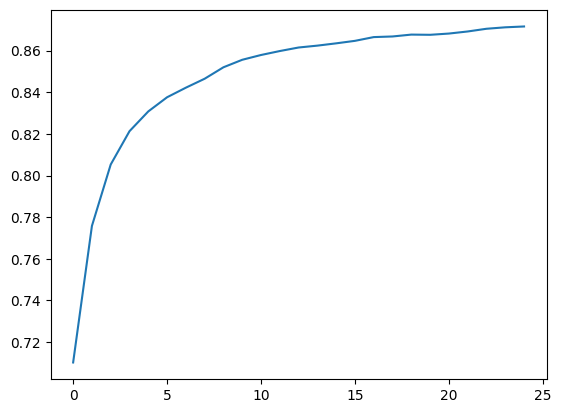

In [8]:
nn = NN_batch(input_nodes, l_r_start=0.01, l_r_end=0.005)

# nn.add_layer(Layer(hidden_nodes, sigmoid))
nn.add_layer(Layer(output_nodes, sigmoid))

nn.fit_epochs_batch(X, y, X_test, y_test, 25, 50)
plt.plot(nn.epochs, nn.efficiency)
print(max(nn.efficiency))
print(np.argmax(nn.efficiency))

In [10]:
# check random value
i = 10
print(y_test[i])
nn_answer = nn.predict(X_test[i])
# print(nn_answer)
np.argmax(nn_answer)

0


0

# Tanh

In [11]:
path_train = '/content/sample_data/mnist_train_small.csv'
training_data_file = open(path_train, 'r')
training_data_list = training_data_file.readlines()
training_data_list = training_data_list[:1_000]
training_data_file.close()
X, y = prepare_data(training_data_list)
X = X/0.5
path_test = "/content/sample_data/mnist_test.csv"
test_data_file = open(path_test, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
X_test, y_test = prepare_data(test_data_list)
X_test = X_test / 0.5

In [12]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate_start = 0.05
learning_rate_end = 0.001

In [13]:
# the bias is necessary for positive tanh values. If we take it without bias, then the values can compensate for each other, because the values of the tanh are from -1 to 1
bias = 1
hyper_tan = Activation_Function(
        lambda x : np.tanh(x) + bias,
        lambda x : 1 - pow(np.tanh(x), 2) + bias,
        -1 + bias, 1 + bias
)

24 0.8444


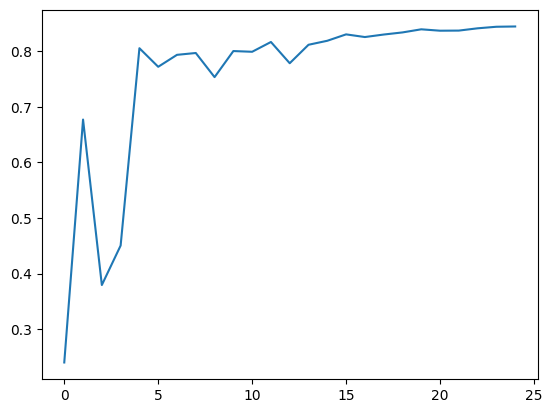

In [15]:
nn_tanh = NN_batch(input_nodes, l_r_start=0.01, l_r_end=0.0001)

nn_tanh.add_layer(Layer(hidden_nodes, hyper_tan))
nn_tanh.add_layer(Layer(output_nodes, hyper_tan))

nn_tanh.fit_epochs_batch(X, y, X_test, y_test, 25, 50)
plt.plot(nn_tanh.epochs, nn_tanh.efficiency)
print(np.argmax(nn_tanh.efficiency), max(nn_tanh.efficiency))